1. [Libraries and Imports](#1)
2. [Statistics](#2)
3. [aa](#3)
4. [bb](#4)
5. [cc](#5)

<a id="1"></a>

### Libraries and Imports

In [158]:
# base 
import os 
import sys
from src import helpers, config, plotting
import random 
import json 
import numpy as np
import pandas as pd 
import pandas.api.types as types
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import missingno as msno
import pickle as pkl
from urllib.request import urlretrieve 
from typing import List, Set, Dict, Tuple
from typing import Union, Any, Optional, Iterable, Hashable

# ml preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier


# validation 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, plot_confusion_matrix

# pipelines 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer

# ignore warnings 
import warnings 
warnings.filterwarnings('ignore')

In [137]:
%matplotlib inline 
sns.set_style('white')
sns.set_palette('deep')
mpl.rcParams['figure.figsize'] = config.DEFAULT_FIGSIZE
mpl.rcParams['lines.linewidth'] = config.DEFAULT_PLOT_LINEWIDTH
mpl.rcParams['lines.linestyle'] = config.DEFAULT_PLOT_LINESTYLE
mpl.rcParams['font.size'] = config.DEFAULT_AXIS_FONT_SIZE

In [35]:
# test
config.TRAIN_FILE_PATH
config.REPORTS_PATH

PosixPath('/home/sanc/data/final')

In [38]:
# the iris dataset is used as a toy df 
from sklearn.datasets import fetch_openml

iris = fetch_openml(name="iris", version=1, as_frame=True)

df = iris['data']
df_target = iris['target']
df = pd.concat([df, df_target], axis=1)
type(df)

pandas.core.frame.DataFrame

In [39]:
df.columns = helpers.standardize_cols(df.columns)
df.columns

Index(['sepallength', 'sepalwidth', 'petallength', 'petalwidth', 'class'], dtype='object')

In [76]:
TARGET = 'class'

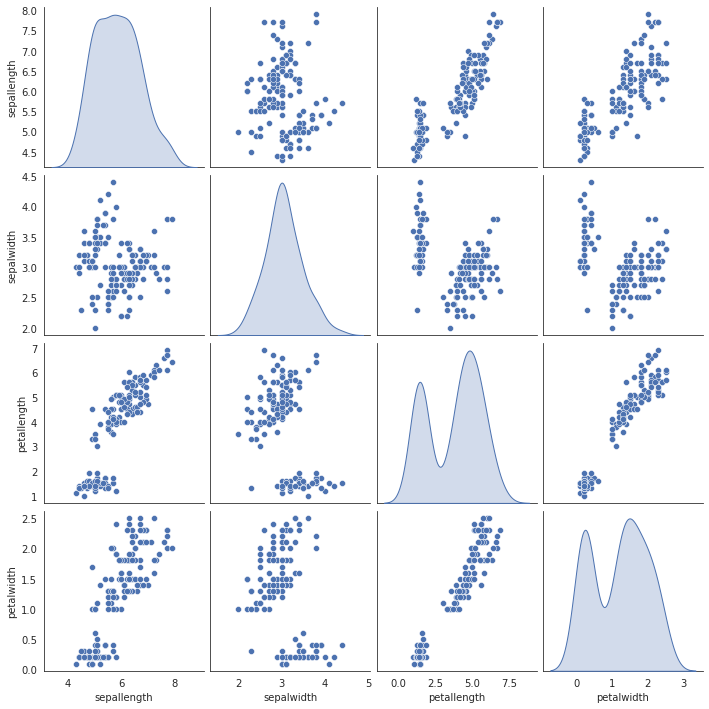

In [40]:
helpers.quick_plot(df)

<a id="2"></a>

### Statistics

In [41]:
helpers.quick_eda(df)

DATAFRAME HAS 150 ROWS AND 5 COLS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sepallength  150 non-null    float64 
 1   sepalwidth   150 non-null    float64 
 2   petallength  150 non-null    float64 
 3   petalwidth   150 non-null    float64 
 4   class        150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB
None


,count,mean,std,min,25%,50%,75%,max
sepallength,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepalwidth,150.0,3.054000,0.433594,2.0,2.8,3.00,3.3,4.4
petallength,150.0,3.758667,1.764420,1.0,1.6,4.35,5.1,6.9
petalwidth,150.0,1.198667,0.763161,0.1,0.3,1.30,1.8,2.5


,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Data preprocessing steps
- Creating - any features to engineer? 
- Correcting - any anomalies to correct? 
- Converting - any dtypes to correct? 
- Completing - any missing values to complete? 

### Completing

Get the numeric and categorical columns for preprocessing

NUMBER OF MISSING COLUMNS: 0
MISSING COLUMNS (0: NO MISSING VALUES, 1: MISSING VALUES
sepallength       0
sepalwidth        0
petallength       0
petalwidth        0
class             0
petallength_ss    0
class_enc         0
dtype: int64


MISSINGNESS THROUGHOUT THE DATA


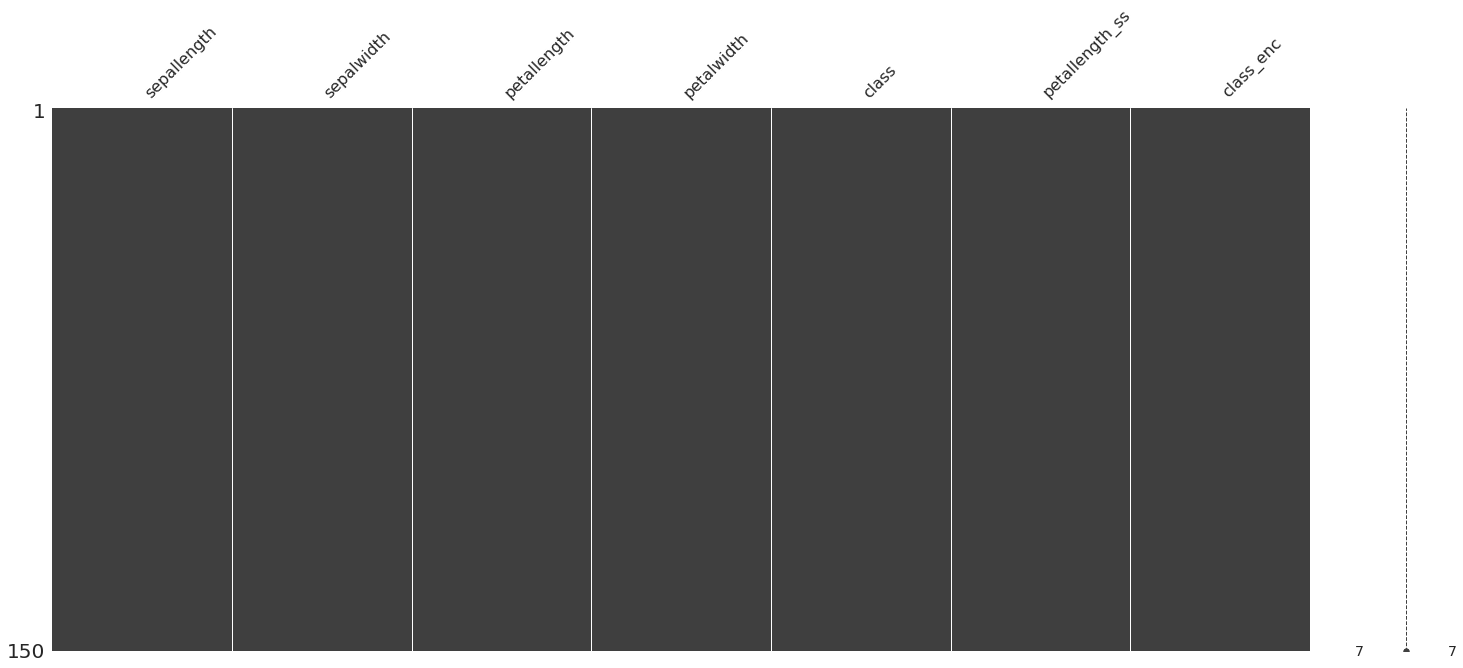

MISSINGNESS CORRELATIONS


/home/sanc/anaconda3/envs/aml/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/sanc/anaconda3/envs/aml/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


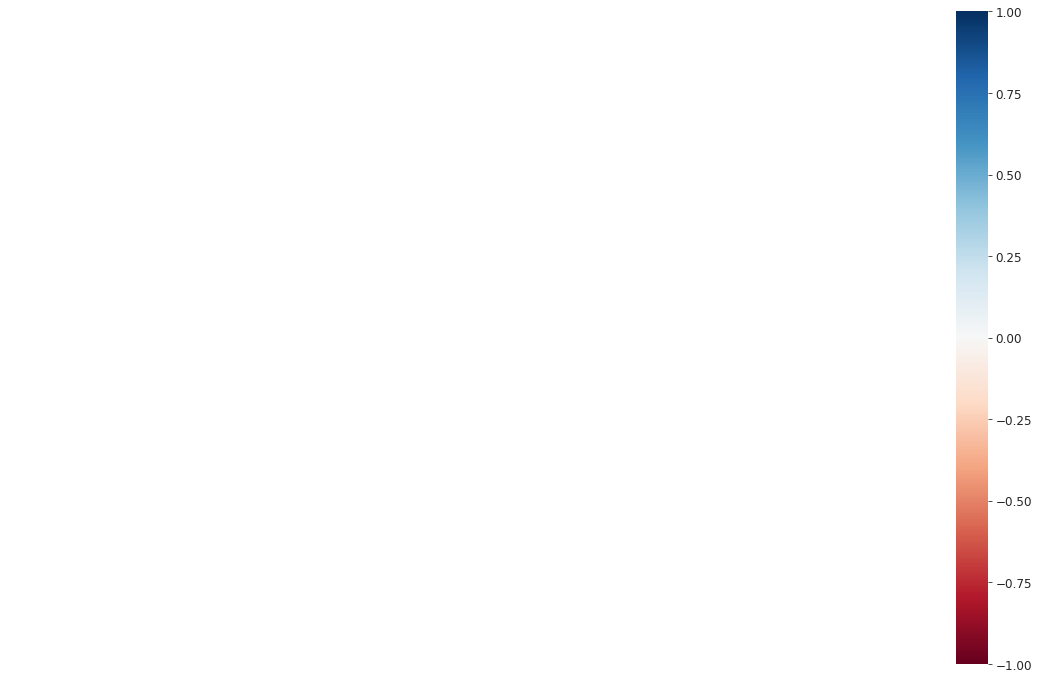

In [118]:
helpers.missingness_checks(df)

In [42]:
df_numeric = df[helpers.get_numeric_columns(df)]
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sepallength  150 non-null    float64
 1   sepalwidth   150 non-null    float64
 2   petallength  150 non-null    float64
 3   petalwidth   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [43]:
df_categorical = df[helpers.get_categorical_columns(df)]
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   class   150 non-null    category
dtypes: category(1)
memory usage: 410.0 bytes


In [44]:
helpers.get_dtypes(df)

{'sepallength': dtype('float64'),
 'sepalwidth': dtype('float64'),
 'petallength': dtype('float64'),
 'petalwidth': dtype('float64'),
 'class': CategoricalDtype(categories=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], ordered=False)}

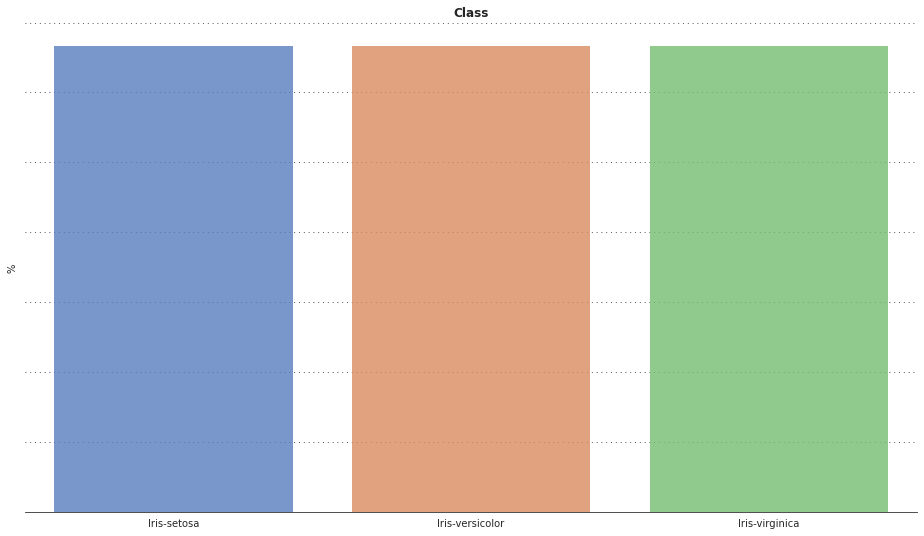

In [45]:
petalwidth_plot = plotting.plotviz(df=df, figsize=(16, 9), rows=1, cols=1, X=['class'], y='petalwidth')
petalwidth_plot.bar()

### Note 

In [46]:
# try to use type hinting where possible so as to prevent unintended behaviour
# Example function 
def double(n: str) -> str: 
    '''
    docstrings here: follow the numpy format
    '''
    return n*2 

In [47]:
## helper functions to add on - preprocessing 

def drop_duplicate_cols(df: pd.DataFrame, cols: Hashable) -> pd.DataFrame: 
    pass  


def check_columns(): pass



## helper functions to add on - visualization
def set_up_fig(nrows: int = 1, ncols: int = 1, figsize: Tuple = (16, 9)) -> None: 
    """Sets up a fig and axes to plot 

    Parameters
    ----------
    nrows : int :
        (Default value = 1)
    ncols : int :
        (Default value = 1)
    figsize : Tuple :
        (Default value = (16, 9))
    Returns
    -------
    A figure and array of axes 
    
    """
    fig, ax = plt.subplots(nrows=nrows, ncols=nrows, figsize=figsize)
    for s in ['top', 'right']: 
        ax.spines[s].set_visible(False)
    # to continue

def plot_corr() -> None: 
    pass 

In [179]:
### Corr

In [48]:
fig = plt.figure()
gs = fig.add_gridspec(1, 1)

ax = fig.add_subplot(gs[0, 0])

cmap = sns.diverging_palette(22, 219, s=80, l=55, as_cmap=True)

sns.heatmap(df.corr(), ax=ax, vmin=-1, vmax=1, annot=True, square=True, cbar=True, cmap=cmap, fmt='.1g')

ax.set_title('Correlation plot', fontweight='bold')

plt.show()

### Preprocessing stuff

In [79]:
enc = LabelEncoder()
df['class_enc'] = enc.fit_transform(df['class'])

In [80]:
df['class_enc']

0      2
1      0
2      0
3      0
4      0
      ..
145    0
146    0
147    2
148    1
149    2
Name: class_enc, Length: 150, dtype: int64

In [85]:
df.columns

Index(['sepallength', 'sepalwidth', 'petallength', 'petalwidth', 'class',
       'petallength_ss', 'class_enc'],
      dtype='object')

### Correlations

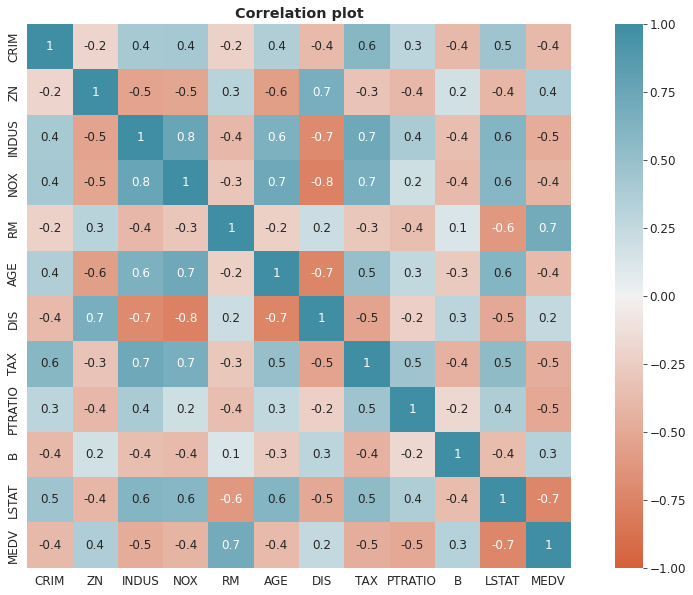

In [57]:
# make dummies 
category_enc = pd.get_dummies(df['class'], drop_first=True)
category_enc


# removing outliers

std = df['petallength'].std()
mean = df['petallength'].mean() 
cutoff = std * 3
lower, upper = mean - cutoff, mean + cutoff

df_trim = df[(df['petallength'] < upper) & (df['petallength'] > lower)]


# scaling data 
SS = StandardScaler() 
df['petallength_ss'] = SS.fit_transform(df[['petallength']])



In [61]:
num_cols = helpers.get_numeric_columns(df)

In [71]:
boxp = plotting.plotviz(df=df[num_cols], X=num_cols, cols=2, rows=2)
boxp.box()

In [93]:
df

,sepallength,sepalwidth,petallength,petalwidth,class,petallength_ss,class_enc
0,7.7,2.6,6.9,2.3,Iris-virginica,1.786341,2
1,5.1,3.8,1.9,0.4,Iris-setosa,-1.056944,0
2,4.4,3.0,1.3,0.2,Iris-setosa,-1.398138,0
3,5.4,3.9,1.7,0.4,Iris-setosa,-1.170675,0
4,5.0,3.5,1.6,0.6,Iris-setosa,-1.227541,0
...,...,...,...,...,...,...,...
145,5.0,3.3,1.4,0.2,Iris-setosa,-1.341272,0
146,5.7,4.4,1.5,0.4,Iris-setosa,-1.284407,0
147,6.5,3.0,5.2,2.0,Iris-virginica,0.819624,2
148,5.6,2.9,3.6,1.3,Iris-versicolor,-0.090227,1


In [94]:
df_ml = df[['sepallength', 'sepalwidth', 'petallength', 'petalwidth', 'class']]

### Train test split

In [99]:
df_ml = df_ml.sample(frac=1).reset_index(drop=True)


X = df_ml.drop(columns=TARGET)
y = df_ml[TARGET]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Hyperparameter tuning

### Randomized search

In [106]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

# create param
param_grid = {'max_depth': [*range(2, 10, 2)],
              'max_features': [*range(1, 3)],
              'min_samples_split': [*range(2, 12, 2)]}

# create a scorer
scorer = make_scorer(accuracy_score)

random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, 
                   n_iter=10, cv=5, scoring=scorer)

In [115]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [2, 4, 6, 8],
                                        'max_features': [1, 2],
                                        'min_samples_split': [2, 4, 6, 8, 10]},
                   scoring=make_scorer(accuracy_score))

In [117]:
display(random_search.cv_results_['mean_test_score'])
print(random_search.best_score_)
print(random_search.best_estimator_)

array([0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.95833333,
       0.96666667, 0.96666667, 0.95833333, 0.95833333, 0.96666667])

0.9666666666666668
RandomForestClassifier(max_depth=6, max_features=1)


### Grid search 

In [107]:
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring=scorer, n_jobs=4, cv=5, refit=True, return_train_score=True)

In [108]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [2, 4, 6, 8], 'max_features': [1, 2],
                         'min_samples_split': [2, 4, 6, 8, 10]},
             return_train_score=True, scoring=make_scorer(accuracy_score))

In [110]:
display(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_score_)
print(grid_search.best_estimator_)

array([0.96666667, 0.95833333, 0.96666667, 0.95833333, 0.95833333,
       0.95833333, 0.95833333, 0.96666667, 0.95833333, 0.95833333,
       0.96666667, 0.95833333, 0.96666667, 0.96666667, 0.95833333,
       0.95833333, 0.95833333, 0.96666667, 0.95833333, 0.95833333,
       0.96666667, 0.96666667, 0.95833333, 0.95833333, 0.95833333,
       0.96666667, 0.96666667, 0.95833333, 0.96666667, 0.96666667,
       0.96666667, 0.95833333, 0.96666667, 0.96666667, 0.95833333,
       0.96666667, 0.95833333, 0.95833333, 0.96666667, 0.95833333])

0.9666666666666668
RandomForestClassifier(max_depth=2, max_features=1)


### Logistic Regression (OVR)

In [140]:
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction import DictVectorizer

In [122]:
# the iris dataset is used as a toy df 
from sklearn.datasets import fetch_openml

boston = fetch_openml(name="boston", version=1, as_frame=True)

df = boston['data']
df_target = boston['target']
df = pd.concat([df, df_target], axis=1)
type(df)

pandas.core.frame.DataFrame

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     506 non-null    float64 
 1   ZN       506 non-null    float64 
 2   INDUS    506 non-null    float64 
 3   CHAS     506 non-null    category
 4   NOX      506 non-null    float64 
 5   RM       506 non-null    float64 
 6   AGE      506 non-null    float64 
 7   DIS      506 non-null    float64 
 8   RAD      506 non-null    category
 9   TAX      506 non-null    float64 
 10  PTRATIO  506 non-null    float64 
 11  B        506 non-null    float64 
 12  LSTAT    506 non-null    float64 
 13  MEDV     506 non-null    float64 
dtypes: category(2), float64(12)
memory usage: 49.0 KB


In [142]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [147]:
from sklearn.svm import SVC

In [153]:
# ultimately, we do want to be making a pipeline 
pp = Pipeline([
        ('ohe', OneHotEncoder()),
        ('le', LabelEncoder()), 
        ('mm', MinMaxScaler()),
        ('clf', OneVsRestClassifier(SVC()))
     ])

In [162]:
# feature union - independently transform features and concat them together
pp_with_feat_union = Pipeline([
        ('features',
        FeatureUnion([
        ('ohe', OneHotEncoder()),
        ('le', LabelEncoder()), 
        ('mm', MinMaxScaler()) 
        ])),
        ('clf', OneVsRestClassifier(SVC()))
     ])

In [166]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     506 non-null    float64 
 1   ZN       506 non-null    float64 
 2   INDUS    506 non-null    float64 
 3   CHAS     506 non-null    category
 4   NOX      506 non-null    float64 
 5   RM       506 non-null    float64 
 6   AGE      506 non-null    float64 
 7   DIS      506 non-null    float64 
 8   RAD      506 non-null    category
 9   TAX      506 non-null    float64 
 10  PTRATIO  506 non-null    float64 
 11  B        506 non-null    float64 
 12  LSTAT    506 non-null    float64 
 13  MEDV     506 non-null    float64 
dtypes: category(2), float64(12)
memory usage: 49.0 KB


In [170]:
from sklearn.feature_extraction.text import CountVectorizer

In [171]:
# column 
col_trans = ColumnTransformer([
        ('cat', OneHotEncoder(), ['AGE', 'DIS']),
        ('text', CountVectorizer(), 'CHAS')
    ],
    remainder='drop')

In [172]:
pp_cols = Pipeline([
    ('cols', col_trans),
    ('clf', OneVsRestClassifier(SVC()))
])

In [174]:
## Visualising pielines
from sklearn import set_config
set_config(display='diagram')

display(pp_with_feat_union)
display(pp)
display(pp_cols)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('ohe', OneHotEncoder()),
                                                ('le', LabelEncoder())])),
                ('clf', OneVsRestClassifier(estimator=SVC()))])

Pipeline(steps=[('ohe', OneHotEncoder()), ('le', LabelEncoder()),
                ('mm', MinMaxScaler()),
                ('clf', OneVsRestClassifier(estimator=SVC()))])

Pipeline(steps=[('cols',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['AGE', 'DIS']),
                                                 ('text', CountVectorizer(),
                                                  'CHAS')])),
                ('clf', OneVsRestClassifier(estimator=SVC()))])

In [132]:
df.RAD.head()

0    1
1    2
2    2
3    3
4    3
Name: RAD, dtype: category
Categories (9, object): ['1', '2', '3', '4', ..., '6', '7', '8', '24']

In [131]:
dv = df.to_dict('RAD')

dvec = DictVectorizer(sparse=False)

df_encoded = dvec.fit_transform(dv)

df_encoded

/tmp/ipykernel_11200/809962007.py:1: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  dv = df.to_dict('RAD')


array([[ 65.2  , 396.9  ,   1.   , ...,   6.575, 296.   ,  18.   ],
       [ 78.9  , 396.9  ,   1.   , ...,   6.421, 242.   ,   0.   ],
       [ 61.1  , 392.83 ,   1.   , ...,   7.185, 242.   ,   0.   ],
       ...,
       [ 91.   , 396.9  ,   1.   , ...,   6.976, 273.   ,   0.   ],
       [ 89.3  , 393.45 ,   1.   , ...,   6.794, 273.   ,   0.   ],
       [ 80.8  , 396.9  ,   1.   , ...,   6.03 , 273.   ,   0.   ]])

### XGB